In [1]:
import torch
import sys

sys.path.append(r'/user/gr1/delphi/dghezzi/UNet')

from UNet import UNet

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Crea istanza modello (deve avere la stessa architettura usata in training)
model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("best_unet_NOattention.pth", map_location=device))
model.to(device)
model.eval()  # modalità valutazione (disabilita dropout, batchnorm, ecc)


UNet(
  (down1): DoubleConv(
    (block): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )


In [2]:
import cv2
import torch
from torchvision import transforms

img_path = "/user/gr1/delphi/dghezzi/UNet/Models/prova2.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # carica in scala di grigi
img = cv2.resize(img, (800, 800))
img = img.astype('float32') / 255.0  # normalizza
img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)  # [H,W] -> [1,C,H,W] con C=1

img_tensor = img_tensor.to(device)
with torch.no_grad():
    output = model(img_tensor)  # shape: [1, out_channels, 800, 800]

# Se out_channels=1, output è la heatmap predetta
heatmap_pred = output.squeeze().cpu().numpy()  # [800, 800]

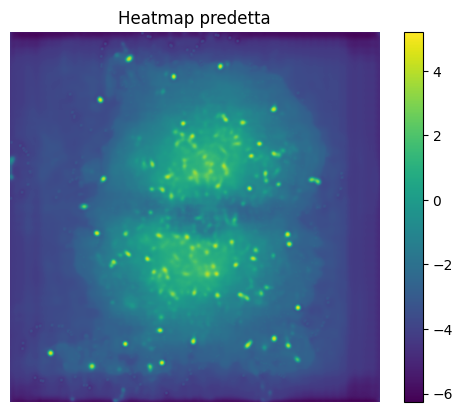

(800, 800)


In [5]:
import matplotlib.pyplot as plt

plt.imshow(heatmap_pred)
plt.title("Heatmap predetta")
plt.colorbar()
plt.axis('off')
plt.show()
plt.imsave("heatmap_predetta.png", heatmap_pred)

print(heatmap_pred.shape)

In [7]:
from UNet import extract_keypoints_from_heatmap, plot_keypoints_with_covariances
'''
# Estrai keypoints e covarianze dalla heatmap
keypoints = extract_keypoints_from_heatmap(heatmap_pred, threshold=0.8)

# Plot keypoints con covarianze
plot_keypoints_with_covariances(keypoints)
'''

'\n# Estrai keypoints e covarianze dalla heatmap\nkeypoints = extract_keypoints_from_heatmap(heatmap_pred, threshold=0.8)\n\n# Plot keypoints con covarianze\nplot_keypoints_with_covariances(keypoints)\n'